#*CVRP:Capacitiated Vechicle Routing Problem*

In [212]:
import numpy as np
import pandas as pd
import pulp
import itertools
import gmaps
import googlemaps
%matplotlib inline

API_KEY = 'YOUR_API_KEY'
gmaps.configure(api_key=API_KEY)
googlemaps = googlemaps.Client(key=API_KEY)

## *Make Dataframe and Plotting Generated Points*

In [181]:
# vending machine count ('0' is depot) 
customer_count = 10

# the number of vehicle
vehicle_count = 4

# the capacity of vehicle
vehicle_capacity = 50

# fix random seed
np.random.seed(seed=0)

# set depot latitude and longitude
# depot is the university of tokyo
depot_latitude = 35.712678
depot_longitude = 139.761989 

In [182]:
# make dataframe which contains vending machine location and demand
df = pd.DataFrame({"latitude":np.random.normal(depot_latitude, 0.01, vending_machine_count), 
                   "longitude":np.random.normal(depot_longitude, 0.02, vending_machine_count), 
                   "demand":np.random.randint(10, 20, vending_machine_count)})

# set the depot as the center and make demand 0 ('0' = depot)
df.iloc[0].latitude = depot_latitude
df.iloc[0].longitude = depot_longitude
df.iloc[0].demand = 0

In [220]:
def _plot_on_gmaps(_df):
    
    _marker_locations = []
    for i in range(len(_df)):
        _marker_locations.append((_df['latitude'].iloc[i],_df['longitude'].iloc[i]))
    
    _fig = gmaps.figure()
    _markers = gmaps.marker_layer(_marker_locations)
    _fig.add_layer(_markers)

    return _fig

In [221]:
plot_result = _plot_on_gmaps(df)
plot_result

Figure(layout=FigureLayout(height='420px'))

## *Calculate Distance of Each Point*
- calculate real distance through google distace matrix

In [202]:
def _distance_calculator(_df):
    
    _distance_result = np.zeros((len(_df),len(_df)))
    for i in range(len(_df)):
        _df['latitude-longitude'].iloc[i] = str(_df.latitude[i]) + ',' + str(_df.longitude[i])
    
    for i in range(len(_df)):
        for j in range(len(_df)):
            
            # calculate distance of all pairs
            _google_maps_api_result = googlemaps.directions(_df['latitude-longitude'].iloc[i],
                                                            _df['latitude-longitude'].iloc[j],
                                                            mode = 'driving')
            # append distance to result list
            _distance_result[i][j] = _google_maps_api_result[0]['legs'][0]['distance']['value']
    
    return _distance_result

In [203]:
distance = _distance_calculator(df)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## *Solve CVRP problem with Pulp*

In [205]:
for vehicle_count in range(1,vehicle_count+1):
    
    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    # add objective function
    problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count) 
                          for j in range(customer_count) 
                          for i in range (customer_count))

    # constraints
    # foluma (2)
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                              for i in range(customer_count) 
                              for k in range(vehicle_count)) == 1 

    # foluma (3)
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    # foluma (4)
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    #foluma (5)
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity 


    # fomula (6)
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    
    # print vehicle_count which needed for solving problem
    # print calculated minimum distance value
    if problem.solve() == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Moving Distance:', pulp.value(problem.objective))
        break

Vehicle Requirements: 3
Moving Distance: 27329.0


## *Visualization of Optimized Result*

In [214]:
fig = gmaps.figure()
layer = []
color_list = ["red","blue","green"]

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                layer.append(gmaps.directions.Directions(
                    (df.latitude[i],df.longitude[i]),
                    (df.latitude[j],df.longitude[j]),
                    mode='car',stroke_color=color_list[k],stroke_opacity=1.0, stroke_weight=5.0))

In [217]:
for i in range(len(layer)):
    fig.add_layer(layer[i])
    
fig

Figure(layout=FigureLayout(height='420px'))

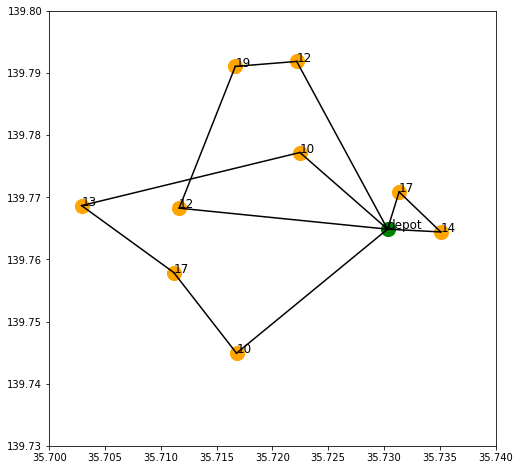

In [231]:
plt.figure(figsize=(8,8))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
        plt.text(df.latitude[i], df.longitude[i], "depot", fontsize=12)
    else:
        plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
        plt.text(df.latitude[i], df.longitude[i], str(df.demand[i]), fontsize=12)

plt.xlim(35.7,35.74)
plt.ylim(139.73,139.80)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")

plt.show()